In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pytorch_lightning import Callback, LightningDataModule, LightningModule, Trainer
from IPython.display import HTML
from torchmetrics import MaxMetric, MeanMetric
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torch import Tensor
from pytorch_lightning import LightningDataModule
from typing import Any, Dict, Optional, Tuple


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/home/ozo/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

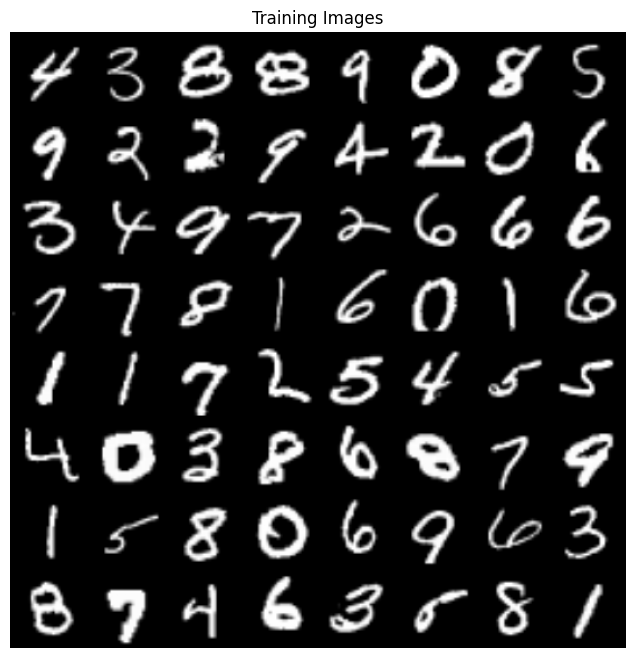

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
from torchvision.datasets import MNIST

dataset = MNIST(root="../data/", train=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                            #    transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.



## Pytorch Lightning

In [11]:
class GANMNISTDataModule(LightningDataModule):
    """Example of LightningDataModule for MNIST dataset.

    A DataModule implements 5 key methods:

        def prepare_data(self):
            # things to do on 1 GPU/TPU (not on every GPU/TPU in DDP)
            # download data, pre-process, split, save to disk, etc...
        def setup(self, stage):
            # things to do on every process in DDP
            # load data, set variables, etc...
        def train_dataloader(self):
            # return train dataloader
        def val_dataloader(self):
            # return validation dataloader
        def test_dataloader(self):
            # return test dataloader
        def teardown(self):
            # called on every process in DDP
            # clean up after fit or test

    This allows you to share a full dataset without explaining how to download,
    split, transform and process the data.

    Read the docs:
        https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html
    """

    def __init__(
        self,
        data_dir: str = "data/",
        batch_size: int = 128,
        num_workers: int = 0,
        transform: Tensor = None,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        self.transforms = transform

    def prepare_data(self):
        """Download data if needed.

        Do not use it to assign state (self.x = y).
        """
        MNIST(self.hparams.data_dir, train=True, download=True)
        MNIST(self.hparams.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.

        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        if stage == "fit" or stage is None:
            self.data_train = MNIST(self.hparams.data_dir, train=True, transform=self.transforms)

        if stage == "test" or stage is None:
            self.data_test = MNIST(self.hparams.data_dir, train=False, transform=self.transforms)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            shuffle=True,
            drop_last=True
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
        )

In [12]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, 1, 1, device=device)

In [13]:
class DCGAN(LightningModule):

    def __init__(
        self,
        gen: torch.nn.Module,
        disc: torch.nn.Module,
        lr: float,
        z_dim: int = 10,
        device='cpu'
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False, ignore=['gen', 'disc'])

        self.gen = gen.to(device).apply(weights_init)
        self.disc = disc.to(device).apply(weights_init)

        self.gen_loss = MeanMetric()
        self.disc_loss = MeanMetric()

        self.opt_g = torch.optim.Adam(self.gen.parameters(), lr, betas=(0.5, 0.9999))
        self.opt_d = torch.optim.Adam(self.disc.parameters(), lr, betas=(0.5, 0.9999))

        # loss function
        self.criterion = torch.nn.BCEWithLogitsLoss()

    def forward(self, x: torch.Tensor):
        return self.gen(x)

    def get_disc_loss(self, real, num_images):
        # Create noise vectors and generate a batch (num_images) of fake images. 
        noise = get_noise(num_images, self.hparams.z_dim, device=self.device)
        fake = self.gen(noise)

        # Get the discriminator's prediction of the fake image 
        # and calculate the loss.
        fake_pred = self.disc(fake.detach())
        
        # Get the discriminator's prediction of the real image and calculate the loss.
        real_pred = self.disc(real)

        # Calculate the discriminator's loss by averaging the real 
        # and fake loss and set it to disc_loss.
        fake_loss = self.criterion(fake_pred, torch.zeros_like(fake_pred))
        real_loss = self.criterion(real_pred, torch.ones_like(real_pred))
        disc_loss = (fake_loss + real_loss) / 2

        return disc_loss

    def get_gen_loss(self, num_images): 
        # Create noise vectors and generate a batch of fake images. 
        noise = get_noise(num_images, self.hparams.z_dim, device=self.device)
        fake = self.gen(noise)

        # Get the discriminator's prediction of the fake image.
        fake_pred = self.disc(fake)
        # Calculate the generator's loss.
        gen_loss = self.criterion(fake_pred, torch.ones_like(fake_pred))
        return gen_loss

    def training_step(self, batch, batch_idx, optimizer_idx):
        # Flatten the batch of real images from the dataset
        real = batch[0]
        print(batch_idx)
        if (optimizer_idx == 1):
            _disc_loss = self.get_disc_loss(real, len(real))
            self.disc_loss(_disc_loss)
            self.log("disc_loss", self.disc_loss, on_step=False, on_epoch=True, prog_bar=True)
            return _disc_loss
        else:
            _gen_loss = self.get_gen_loss(len(real))
            self.gen_loss(_gen_loss)
            self.log("gen_loss", self.gen_loss, on_step=False, on_epoch=True, prog_bar=True)
            return _gen_loss


    def configure_optimizers(self):
        opt_d = self.opt_d
        opt_g = self.opt_g

        return [{"optimizer": opt_g}, {"optimizer": opt_d}]


In [14]:
model = DCGAN(netG, netD, 0.0002, 100, device="cuda")

In [15]:
datamodule = GANMNISTDataModule(transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
  ]))
datamodule.setup()

In [16]:
next(iter(datamodule.train_dataloader()))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [17]:
trainer = Trainer(min_epochs=1, max_epochs=50, accelerator="gpu", check_val_every_n_epoch=1, deterministic=False)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model=model, datamodule=datamodule, ckpt_path="")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | gen       | Generator         | 3.6 M 
1 | disc      | Discriminator     | 2.8 M 
2 | gen_loss  | MeanMetric        | 0     
3 | disc_loss | MeanMetric        | 0     
4 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.353    Total estimated model params size (MB)
/home/ozo/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/468 [00:00<?, ?it/s] 0
0
Epoch 0:   0%|          | 1/468 [00:00<07:43,  1.01it/s, loss=0.754, v_num=3]1
1
Epoch 0:   0%|          | 2/468 [00:01<04:32,  1.71it/s, loss=0.712, v_num=3]2
2
Epoch 0:   1%|          | 3/468 [00:01<03:28,  2.23it/s, loss=0.675, v_num=3]3
3
Epoch 0:   1%|          | 4/468 [00:01<02:57,  2.62it/s, loss=0.656, v_num=3]4
4
Epoch 0:   1%|          | 5/468 [00:01<02:37,  2.94it/s, loss=0.645, v_num=3]5
5
Epoch 0:   1%|▏         | 6/468 [00:01<02:23,  3.21it/s, loss=0.637, v_num=3]6
6
Epoch 0:   1%|▏         | 7/468 [00:02<02:14,  3.43it/s, loss=0.631, v_num=3]7
7
Epoch 0:   2%|▏         | 8/468 [00:02<02:06,  3.62it/s, loss=0.627, v_num=3]8
8
Epoch 0:   2%|▏         | 9/468 [00:02<02:01,  3.79it/s, loss=0.624, v_num=3]9
9
Epoch 0:   2%|▏         | 10/468 [00:02<01:56,  3.93it/s, loss=0.621, v_num=3]10
10
Epoch 0:   2%|▏         | 11/468 [00:02<01:52,  4.05it/s, loss=0.606, v_num=3]11
11
Epoch 0:   3%|▎         | 12/468 [00:02<01:49,  4.

/home/ozo/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Pytorch

In [19]:
def train():
    # Setup Adam optimizers for both G and D

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    # Training Loop

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
            
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

In [ ]:
train()